In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Scrapping import BeautifulSoupScrape as BSC
from Project_Final_Scripts.date_utils import date_range
import time
import json

In [2]:
corona_ratio_data = '..\\corona_lb_ratios.csv'

pd.set_option('display.max_rows', 255)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
df = pd.read_csv(corona_ratio_data, header=0)
df.head()

,date,year,month,day,new_cases,new_deaths,local,travelers,prev_cases,prev_deaths,total_cases,total_deaths,month_avg_ratio,cumulative_avg_ratio,diff_avg_ratio,simple_ratio
0,2/1/2020,2020,2,1,0,0,1,0,0,0,0,0,-1.0,-1.0,-0.111737,-0.055159
1,2/2/2020,2020,2,2,0,0,1,0,0,0,0,0,-1.0,-1.0,-0.111737,-0.055159
2,2/3/2020,2020,2,3,0,0,1,0,0,0,0,0,-1.0,-1.0,-0.111737,-0.055159
3,2/4/2020,2020,2,4,0,0,1,0,0,0,0,0,-1.0,-1.0,-0.111737,-0.055159
4,2/5/2020,2020,2,5,0,0,1,0,0,0,0,0,-1.0,-1.0,-0.111737,-0.055159


In [4]:
x = df.month.map(str) + '_' + df.day.map(str)
y = df.diff_avg_ratio

zero = [0 for _ in range(len(x))]

max_value = df.diff_avg_ratio.max()
maximum = [max_value for _ in range(len(x))]

min_value = df.diff_avg_ratio.min()
minimum = [min_value for _ in range(len(x))]

std_value = df.diff_avg_ratio.std()
pos_std = [std_value for _ in range(len(x))]
neg_std = [-std_value for _ in range(len(x))]

print('max:', max_value)
print('min:', min_value)
print('std:', std_value)

max: 1.0000000000000002
min: -1.0
std: 0.2476300065068208


In [5]:
hotspots_data = []
hotspots = []

def get_source(row):
    if row.local:
        source = 'locals'
        if row.travelers:
            source += '_travelers'
    else:
        source = 'travelers'
    return source

for index, row in df.iterrows():
    # negative hotspots
    if row.diff_avg_ratio < -std_value:
        hotspots_data.append({
            'date': row.date,
            'prev_cases': row.prev_cases,
            'new_cases': row.new_cases,
            'cases_diff': abs(row.new_cases - row.prev_cases),
            'ratio': row.diff_avg_ratio,
            'source': get_source(row)
        })
        hotspots.append(row.diff_avg_ratio)
        
    else:
        hotspots.append(0)
        
    
print(len(hotspots_data), 'negative hotspots')
print(len(hotspots), 'spots')

55 negative hotspots
237 spots


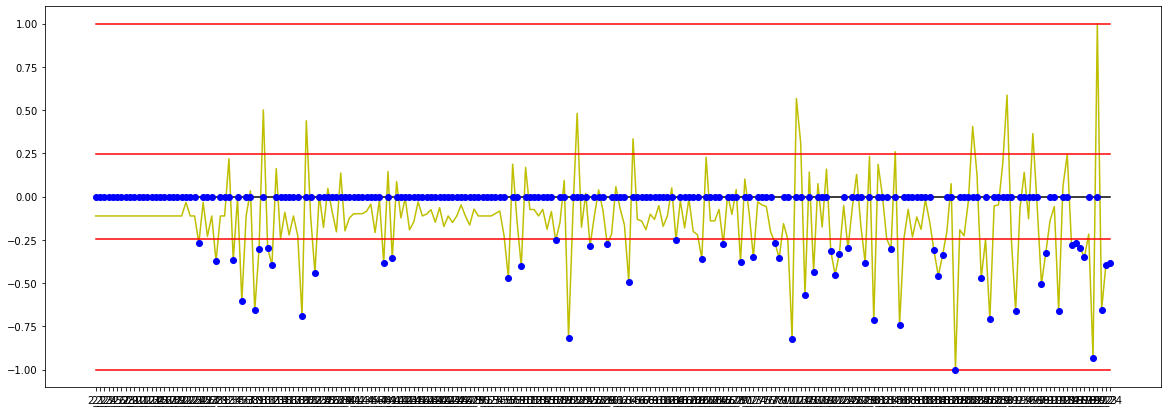

In [6]:
plt.figure(figsize=(20, 7))
plt.plot(
    x, y, 'y', 
    x, zero, 'black',
    x, maximum, 'r', 
    x, minimum, 'r', 
    x, pos_std, 'r',
    x, neg_std, 'r',
    x, hotspots, 'bo'
)

In [7]:
for hotspot in hotspots_data:
    print(hotspot)
    print('---------------------------------------------------------------------------------------------------------------------------------------------')

{'date': '2/25/2020', 'prev_cases': 0, 'new_cases': 1, 'cases_diff': 1, 'ratio': -0.2693279105758257, 'source': 'locals'}
---------------------------------------------------------------------------------------------------------------------------------------------
{'date': '2/29/2020', 'prev_cases': 1, 'new_cases': 3, 'cases_diff': 2, 'ratio': -0.3743887116133297, 'source': 'locals'}
---------------------------------------------------------------------------------------------------------------------------------------------
{'date': '3/4/2020', 'prev_cases': 0, 'new_cases': 2, 'cases_diff': 2, 'ratio': -0.3638826315095793, 'source': 'locals'}
---------------------------------------------------------------------------------------------------------------------------------------------
{'date': '3/6/2020', 'prev_cases': 1, 'new_cases': 6, 'cases_diff': 5, 'ratio': -0.6042092138828695, 'source': 'locals'}
----------------------------------------------------------------------------------------

In [8]:
def get_trends(dates):
    final_trends = []
    
    for date in dates:
        # get trends
        trends = BSC.get_elements(
            "div.col-lg-8 > div > ul > li > a",
            source=f'https://trendogate.com/placebydate/23424873/{date}',
            attributes=True
        )
        # get trends data
        for trend in trends:
            final_trends.append({
                'topic': trend['text'].strip(),
                'link': 'https://trendogate.com/' + trend['href'],
                'tweets': []
            })

        # sleep
        time.sleep(0.5)

    return final_trends

#----------------------------------------------------------------------------------------------------

def get_hotspot_topics(date):
    global hotspots_topics_trends

    dates = date_range(date, '%m/%d/%Y', range_before=3, range_after=0)
    trends = get_trends(dates)

    print('[Date]:', date)
    print('[Trends]:', trends)
    print('------------------------------------------')

    return trends

#----------------------------------------------------------------------------------------------------

def get_hotspots_topics(hotspots):
    hotspots_trends = {}

    for hotspot in hotspots:
        trends = []
        if hotspot['source'] == 'locals':
            trends = get_hotspot_topics(hotspot['date'])
        hotspots_trends[hotspot['date']] = {
                **hotspot,
                'trends': trends
            }    

    with open('hotspots.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(hotspots_trends, indent=2, ensure_ascii=False))
    
    print('Done!!')

In [9]:
get_hotspots_topics(hotspots_data)

[Date]: 2/25/2020
[Trends]: [{'topic': '#نجوي_كرم', 'link': 'https://trendogate.com//trend/95021308', 'tweets': []}, {'topic': '#روسيا', 'link': 'https://trendogate.com//trend/95021307', 'tweets': []}, {'topic': '#صناع_الامل', 'link': 'https://trendogate.com//trend/95021306', 'tweets': []}, {'topic': '#vivoreeesclito', 'link': 'https://trendogate.com//trend/95021305', 'tweets': []}, {'topic': '#جنبلاط', 'link': 'https://trendogate.com//trend/95021304', 'tweets': []}, {'topic': '#اردوغان', 'link': 'https://trendogate.com//trend/95021303', 'tweets': []}, {'topic': '#Egypt', 'link': 'https://trendogate.com//trend/95021302', 'tweets': []}, {'topic': '#Unews', 'link': 'https://trendogate.com//trend/95021301', 'tweets': []}, {'topic': '#breaking', 'link': 'https://trendogate.com//trend/95021300', 'tweets': []}, {'topic': '#fibaasiacup', 'link': 'https://trendogate.com//trend/95021299', 'tweets': []}, {'topic': '#btskineticfilmon', 'link': 'https://trendogate.com//trend/95021298', 'tweets': [

[Date]: 2/29/2020
[Trends]: [{'topic': '#كوريا_الجنوبيه', 'link': 'https://trendogate.com//trend/95290591', 'tweets': []}, {'topic': '#Idlib', 'link': 'https://trendogate.com//trend/95290590', 'tweets': []}, {'topic': '#qatar', 'link': 'https://trendogate.com//trend/95290589', 'tweets': []}, {'topic': '#egypt', 'link': 'https://trendogate.com//trend/95290588', 'tweets': []}, {'topic': '#نجوي_كرم', 'link': 'https://trendogate.com//trend/95290587', 'tweets': []}, {'topic': '#ريال_مدريد', 'link': 'https://trendogate.com//trend/95290586', 'tweets': []}, {'topic': '#Bahrain', 'link': 'https://trendogate.com//trend/95290585', 'tweets': []}, {'topic': '#Algeria', 'link': 'https://trendogate.com//trend/95290584', 'tweets': []}, {'topic': '#Eurobonds', 'link': 'https://trendogate.com//trend/95290583', 'tweets': []}, {'topic': '#فرنسا', 'link': 'https://trendogate.com//trend/95290582', 'tweets': []}, {'topic': '#حركه_المرور', 'link': 'https://trendogate.com//trend/95290581', 'tweets': []}, {'top

[Date]: 3/4/2020
[Trends]: [{'topic': '#btsarmy', 'link': 'https://trendogate.com//trend/95540422', 'tweets': []}, {'topic': '#Health', 'link': 'https://trendogate.com//trend/95540421', 'tweets': []}, {'topic': '#BREAKING', 'link': 'https://trendogate.com//trend/95540420', 'tweets': []}, {'topic': '#bestfanarmy', 'link': 'https://trendogate.com//trend/95540419', 'tweets': []}, {'topic': '#coronavirusupdates', 'link': 'https://trendogate.com//trend/95540418', 'tweets': []}, {'topic': '#fif2020lb', 'link': 'https://trendogate.com//trend/95540417', 'tweets': []}, {'topic': '#Russia', 'link': 'https://trendogate.com//trend/95540416', 'tweets': []}, {'topic': '#وزاره_الصحه', 'link': 'https://trendogate.com//trend/95540415', 'tweets': []}, {'topic': '#لا_داعي_للهلع', 'link': 'https://trendogate.com//trend/95540414', 'tweets': []}, {'topic': '#Idlib', 'link': 'https://trendogate.com//trend/95540413', 'tweets': []}, {'topic': '#بوتين', 'link': 'https://trendogate.com//trend/95540412', 'tweets'

[Date]: 3/6/2020
[Trends]: [{'topic': '#برشلونه', 'link': 'https://trendogate.com//trend/95676618', 'tweets': []}, {'topic': '#فرنسا', 'link': 'https://trendogate.com//trend/95676617', 'tweets': []}, {'topic': '#اردوغان', 'link': 'https://trendogate.com//trend/95676616', 'tweets': []}, {'topic': '#iHeartAwards', 'link': 'https://trendogate.com//trend/95676615', 'tweets': []}, {'topic': '#للفساد_زعيم_يحميه', 'link': 'https://trendogate.com//trend/95676614', 'tweets': []}, {'topic': '#engl256b', 'link': 'https://trendogate.com//trend/95676613', 'tweets': []}, {'topic': '#btsarmy', 'link': 'https://trendogate.com//trend/95676612', 'tweets': []}, {'topic': '#دياب', 'link': 'https://trendogate.com//trend/95676611', 'tweets': []}, {'topic': '#HalaMadrid', 'link': 'https://trendogate.com//trend/95676610', 'tweets': []}, {'topic': '#دمشق', 'link': 'https://trendogate.com//trend/95676609', 'tweets': []}, {'topic': '#كورونا_في_لبنان', 'link': 'https://trendogate.com//trend/95676608', 'tweets': [

[Date]: 3/9/2020
[Trends]: [{'topic': '#كلن_يعني_كلن', 'link': 'https://trendogate.com//trend/95904144', 'tweets': []}, {'topic': '#gaming', 'link': 'https://trendogate.com//trend/95904143', 'tweets': []}, {'topic': '#lebanonprotests', 'link': 'https://trendogate.com//trend/95904142', 'tweets': []}, {'topic': '#العوده', 'link': 'https://trendogate.com//trend/95904141', 'tweets': []}, {'topic': '#كورونا_في_العراق', 'link': 'https://trendogate.com//trend/95904140', 'tweets': []}, {'topic': '#الاسد', 'link': 'https://trendogate.com//trend/95904139', 'tweets': []}, {'topic': '#gamedev', 'link': 'https://trendogate.com//trend/95904138', 'tweets': []}, {'topic': '#ثوره_سرقها_الزعران', 'link': 'https://trendogate.com//trend/95904137', 'tweets': []}, {'topic': '#الدولار', 'link': 'https://trendogate.com//trend/95904136', 'tweets': []}, {'topic': '#لبنان_يثور', 'link': 'https://trendogate.com//trend/95904135', 'tweets': []}, {'topic': '#النقابه_تنتفض', 'link': 'https://trendogate.com//trend/959

[Date]: 3/10/2020
[Trends]: [{'topic': '#رياض_سلامه', 'link': 'https://trendogate.com//trend/95972744', 'tweets': []}, {'topic': '#الدولار', 'link': 'https://trendogate.com//trend/95972743', 'tweets': []}, {'topic': '#تونس', 'link': 'https://trendogate.com//trend/95972742', 'tweets': []}, {'topic': '#ثوره_سرقها_الزعران', 'link': 'https://trendogate.com//trend/95972741', 'tweets': []}, {'topic': '#نبيه_بري', 'link': 'https://trendogate.com//trend/95972740', 'tweets': []}, {'topic': '#Corona', 'link': 'https://trendogate.com//trend/95972739', 'tweets': []}, {'topic': '#يسقط_حكم_المصرف', 'link': 'https://trendogate.com//trend/95972738', 'tweets': []}, {'topic': '#مصرف_لبنان', 'link': 'https://trendogate.com//trend/95972737', 'tweets': []}, {'topic': '#السعوديه', 'link': 'https://trendogate.com//trend/95972736', 'tweets': []}, {'topic': '#لن_ندفع', 'link': 'https://trendogate.com//trend/95972735', 'tweets': []}, {'topic': '#شكرا_للمتطوعين', 'link': 'https://trendogate.com//trend/95972734',

[Date]: 3/12/2020
[Trends]: [{'topic': '#محمد_بن_سلمان', 'link': 'https://trendogate.com//trend/96083192', 'tweets': []}, {'topic': '#نجوي_كرم', 'link': 'https://trendogate.com//trend/96083191', 'tweets': []}, {'topic': '#GenerationEquality', 'link': 'https://trendogate.com//trend/96083190', 'tweets': []}, {'topic': '#genderequality', 'link': 'https://trendogate.com//trend/96083189', 'tweets': []}, {'topic': '#happywomensday', 'link': 'https://trendogate.com//trend/96083188', 'tweets': []}, {'topic': '#وليد_الكعبه', 'link': 'https://trendogate.com//trend/96083187', 'tweets': []}, {'topic': '#PhotosOfMyLife', 'link': 'https://trendogate.com//trend/96083186', 'tweets': []}, {'topic': '#السعوديه', 'link': 'https://trendogate.com//trend/96083185', 'tweets': []}, {'topic': '#المراه', 'link': 'https://trendogate.com//trend/96083184', 'tweets': []}, {'topic': '#ريال_مدريد', 'link': 'https://trendogate.com//trend/96083183', 'tweets': []}, {'topic': '#ولاده_الامير', 'link': 'https://trendogate.

[Date]: 3/13/2020
[Trends]: [{'topic': '#genderequality', 'link': 'https://trendogate.com//trend/96151517', 'tweets': []}, {'topic': '#algeria', 'link': 'https://trendogate.com//trend/96151516', 'tweets': []}, {'topic': '#ENGL256B', 'link': 'https://trendogate.com//trend/96151515', 'tweets': []}, {'topic': '#الامارات', 'link': 'https://trendogate.com//trend/96151514', 'tweets': []}, {'topic': '#ديما_الواطيه', 'link': 'https://trendogate.com//trend/96151513', 'tweets': []}, {'topic': '#BoyWithLuv', 'link': 'https://trendogate.com//trend/96151512', 'tweets': []}, {'topic': '#ايطاليا', 'link': 'https://trendogate.com//trend/96151511', 'tweets': []}, {'topic': '#mufc', 'link': 'https://trendogate.com//trend/96151510', 'tweets': []}, {'topic': '#bestmusicvideo', 'link': 'https://trendogate.com//trend/96151509', 'tweets': []}, {'topic': '#شو_بعد_ناطرنا', 'link': 'https://trendogate.com//trend/96151508', 'tweets': []}, {'topic': '#يا_زينب_الكبري', 'link': 'https://trendogate.com//trend/961515

[Date]: 3/20/2020
[Trends]: [{'topic': '#طرابلس', 'link': 'https://trendogate.com//trend/96560333', 'tweets': []}, {'topic': '#فرنسا', 'link': 'https://trendogate.com//trend/96560332', 'tweets': []}, {'topic': '#zalimistanbul', 'link': 'https://trendogate.com//trend/96560331', 'tweets': []}, {'topic': '#socialdistancing', 'link': 'https://trendogate.com//trend/96560330', 'tweets': []}, {'topic': '#انتم_اونلاين', 'link': 'https://trendogate.com//trend/96560329', 'tweets': []}, {'topic': '#راغب_علامه', 'link': 'https://trendogate.com//trend/96560328', 'tweets': []}, {'topic': '#lockdown', 'link': 'https://trendogate.com//trend/96560327', 'tweets': []}, {'topic': '#jordan', 'link': 'https://trendogate.com//trend/96560326', 'tweets': []}, {'topic': '#فعاليات_الحجر_المنزلي', 'link': 'https://trendogate.com//trend/96560325', 'tweets': []}, {'topic': '#زمن_الكورونا', 'link': 'https://trendogate.com//trend/96560324', 'tweets': []}, {'topic': '#مشاهير', 'link': 'https://trendogate.com//trend/96

[Date]: 3/23/2020
[Trends]: [{'topic': '#المانيا', 'link': 'https://trendogate.com//trend/96742423', 'tweets': []}, {'topic': '#staysafestayhome', 'link': 'https://trendogate.com//trend/96742422', 'tweets': []}, {'topic': '#اميركا', 'link': 'https://trendogate.com//trend/96742421', 'tweets': []}, {'topic': '#she_earned_it', 'link': 'https://trendogate.com//trend/96742420', 'tweets': []}, {'topic': '#mentalhealth', 'link': 'https://trendogate.com//trend/96742419', 'tweets': []}, {'topic': '#وزاره_الصحه', 'link': 'https://trendogate.com//trend/96742418', 'tweets': []}, {'topic': '#صباح_الخير', 'link': 'https://trendogate.com//trend/96742417', 'tweets': []}, {'topic': '#mtvlebanon', 'link': 'https://trendogate.com//trend/96742416', 'tweets': []}, {'topic': '#العميل_عامر_الفاخوري', 'link': 'https://trendogate.com//trend/96742415', 'tweets': []}, {'topic': '#فاخوري', 'link': 'https://trendogate.com//trend/96742414', 'tweets': []}, {'topic': '#الفاخوري', 'link': 'https://trendogate.com//tren

[Date]: 5/18/2020
[Trends]: [{'topic': '#lockdown', 'link': 'https://trendogate.com//trend/99809866', 'tweets': []}, {'topic': '#Turkey', 'link': 'https://trendogate.com//trend/99809865', 'tweets': []}, {'topic': '#سوريا', 'link': 'https://trendogate.com//trend/99809864', 'tweets': []}, {'topic': '#سهرانين_معاكم_بالبيت', 'link': 'https://trendogate.com//trend/99809863', 'tweets': []}, {'topic': '#Iraq', 'link': 'https://trendogate.com//trend/99809862', 'tweets': []}, {'topic': '#StayAtHome', 'link': 'https://trendogate.com//trend/99809861', 'tweets': []}, {'topic': '#رياض_سلامه', 'link': 'https://trendogate.com//trend/99809860', 'tweets': []}, {'topic': '#حزب_الله', 'link': 'https://trendogate.com//trend/99809859', 'tweets': []}, {'topic': '#جنبلاط', 'link': 'https://trendogate.com//trend/99809858', 'tweets': []}, {'topic': '#beriut', 'link': 'https://trendogate.com//trend/99809857', 'tweets': []}, {'topic': '#يا_علي', 'link': 'https://trendogate.com//trend/99809856', 'tweets': []}, {'

[Date]: 5/26/2020
[Trends]: [{'topic': '#قاسم_سليماني', 'link': 'https://trendogate.com//trend/100346814', 'tweets': []}, {'topic': '#البحرين', 'link': 'https://trendogate.com//trend/100346813', 'tweets': []}, {'topic': '#IamYLP', 'link': 'https://trendogate.com//trend/100346812', 'tweets': []}, {'topic': '#YLP6', 'link': 'https://trendogate.com//trend/100346811', 'tweets': []}, {'topic': '#مجد_ايار', 'link': 'https://trendogate.com//trend/100346810', 'tweets': []}, {'topic': '#مشاهير', 'link': 'https://trendogate.com//trend/100346809', 'tweets': []}, {'topic': '#حسان_دياب', 'link': 'https://trendogate.com//trend/100346808', 'tweets': []}, {'topic': '#عيد_المقاومه_والتحرير', 'link': 'https://trendogate.com//trend/100346807', 'tweets': []}, {'topic': '#staysafe', 'link': 'https://trendogate.com//trend/100346806', 'tweets': []}, {'topic': '#سنصلي_في_القدس', 'link': 'https://trendogate.com//trend/100346805', 'tweets': []}, {'topic': '#السعوديه', 'link': 'https://trendogate.com//trend/1003

[Date]: 5/30/2020
[Trends]: [{'topic': '#Syria', 'link': 'https://trendogate.com//trend/100612826', 'tweets': []}, {'topic': '#رجاء_الجداوي', 'link': 'https://trendogate.com//trend/100612825', 'tweets': []}, {'topic': '#التيار_الوطني_الحر', 'link': 'https://trendogate.com//trend/100612824', 'tweets': []}, {'topic': '#LBCILebanon', 'link': 'https://trendogate.com//trend/100612823', 'tweets': []}, {'topic': '#tiktok', 'link': 'https://trendogate.com//trend/100612822', 'tweets': []}, {'topic': '#المقاومه', 'link': 'https://trendogate.com//trend/100612821', 'tweets': []}, {'topic': '#Covid_19', 'link': 'https://trendogate.com//trend/100612820', 'tweets': []}, {'topic': '#Algeria', 'link': 'https://trendogate.com//trend/100612819', 'tweets': []}, {'topic': '#بالقلب', 'link': 'https://trendogate.com//trend/100612818', 'tweets': []}, {'topic': '#قهوه_الماضي', 'link': 'https://trendogate.com//trend/100612817', 'tweets': []}, {'topic': '#صباح_الخير', 'link': 'https://trendogate.com//trend/10061

[Date]: 6/4/2020
[Trends]: [{'topic': '#Lebanonprotests', 'link': 'https://trendogate.com//trend/100917692', 'tweets': []}, {'topic': '#مساء_الخير', 'link': 'https://trendogate.com//trend/100917691', 'tweets': []}, {'topic': '#حسن_حسني', 'link': 'https://trendogate.com//trend/100917690', 'tweets': []}, {'topic': '#البيت_الابيض', 'link': 'https://trendogate.com//trend/100917689', 'tweets': []}, {'topic': '#racism', 'link': 'https://trendogate.com//trend/100917688', 'tweets': []}, {'topic': '#Israeli', 'link': 'https://trendogate.com//trend/100917687', 'tweets': []}, {'topic': '#الدولار', 'link': 'https://trendogate.com//trend/100917686', 'tweets': []}, {'topic': '#لبنان_ينتفض', 'link': 'https://trendogate.com//trend/100917685', 'tweets': []}, {'topic': '#الجيش_اللبناني', 'link': 'https://trendogate.com//trend/100917684', 'tweets': []}, {'topic': '#بعلبك', 'link': 'https://trendogate.com//trend/100917683', 'tweets': []}, {'topic': '#georgefloydprotests', 'link': 'https://trendogate.com//

[Date]: 6/15/2020
[Trends]: [{'topic': '#جبران_باسيل', 'link': 'https://trendogate.com//trend/101630843', 'tweets': []}, {'topic': '#كلن_يعني_كلن', 'link': 'https://trendogate.com//trend/101630842', 'tweets': []}, {'topic': '#Trollz', 'link': 'https://trendogate.com//trend/101630841', 'tweets': []}, {'topic': '#بعبدا', 'link': 'https://trendogate.com//trend/101630840', 'tweets': []}, {'topic': '#عهد_الانهيار', 'link': 'https://trendogate.com//trend/101630839', 'tweets': []}, {'topic': '#Hezbollah', 'link': 'https://trendogate.com//trend/101630838', 'tweets': []}, {'topic': '#العهد_الفاشل', 'link': 'https://trendogate.com//trend/101630837', 'tweets': []}, {'topic': '#وايل_كفوري', 'link': 'https://trendogate.com//trend/101630836', 'tweets': []}, {'topic': '#خلده', 'link': 'https://trendogate.com//trend/101630835', 'tweets': []}, {'topic': '#تعلبايا', 'link': 'https://trendogate.com//trend/101630834', 'tweets': []}, {'topic': '#البقاع', 'link': 'https://trendogate.com//trend/101630833', '

[Date]: 6/26/2020
[Trends]: [{'topic': '#اسراييل', 'link': 'https://trendogate.com//trend/102344770', 'tweets': []}, {'topic': '#wwdc20', 'link': 'https://trendogate.com//trend/102344769', 'tweets': []}, {'topic': '#صيدا', 'link': 'https://trendogate.com//trend/102344768', 'tweets': []}, {'topic': '#ليبيا', 'link': 'https://trendogate.com//trend/102344767', 'tweets': []}, {'topic': '#العراق', 'link': 'https://trendogate.com//trend/102344766', 'tweets': []}, {'topic': '#فلسطين', 'link': 'https://trendogate.com//trend/102344765', 'tweets': []}, {'topic': '#لبنان_الحلو', 'link': 'https://trendogate.com//trend/102344764', 'tweets': []}, {'topic': '#بعبدا', 'link': 'https://trendogate.com//trend/102344763', 'tweets': []}, {'topic': '#israel', 'link': 'https://trendogate.com//trend/102344762', 'tweets': []}, {'topic': '#السعوديه', 'link': 'https://trendogate.com//trend/102344761', 'tweets': []}, {'topic': '#المنيه', 'link': 'https://trendogate.com//trend/102344760', 'tweets': []}, {'topic': 

[Date]: 6/30/2020
[Trends]: [{'topic': '#صباح_الخيرᅠ', 'link': 'https://trendogate.com//trend/102587114', 'tweets': []}, {'topic': '#لبنان_يتنفض', 'link': 'https://trendogate.com//trend/102587113', 'tweets': []}, {'topic': '#UN75', 'link': 'https://trendogate.com//trend/102587112', 'tweets': []}, {'topic': '#الامارات', 'link': 'https://trendogate.com//trend/102587111', 'tweets': []}, {'topic': '#ثوره_سرقها_الزعران', 'link': 'https://trendogate.com//trend/102587110', 'tweets': []}, {'topic': '#لبنان__ينتفض', 'link': 'https://trendogate.com//trend/102587109', 'tweets': []}, {'topic': '#البقاع', 'link': 'https://trendogate.com//trend/102587108', 'tweets': []}, {'topic': '#رخيص_الجمهوريه', 'link': 'https://trendogate.com//trend/102587107', 'tweets': []}, {'topic': '#اوقفوا_التعذيب_في_البحرين', 'link': 'https://trendogate.com//trend/102587106', 'tweets': []}, {'topic': '#رياض_سلامه', 'link': 'https://trendogate.com//trend/102587105', 'tweets': []}, {'topic': '#bonvoyage', 'link': 'https://t

[Date]: 7/12/2020
[Trends]: [{'topic': '#ديما_الواطيه', 'link': 'https://trendogate.com//trend/103393898', 'tweets': []}, {'topic': '#Opinion', 'link': 'https://trendogate.com//trend/103393897', 'tweets': []}, {'topic': '#بريطانيا', 'link': 'https://trendogate.com//trend/103393896', 'tweets': []}, {'topic': '#واشنطن', 'link': 'https://trendogate.com//trend/103393895', 'tweets': []}, {'topic': '#China', 'link': 'https://trendogate.com//trend/103393894', 'tweets': []}, {'topic': '#sdgs', 'link': 'https://trendogate.com//trend/103393893', 'tweets': []}, {'topic': '#tayyar', 'link': 'https://trendogate.com//trend/103393892', 'tweets': []}, {'topic': '#الحريري', 'link': 'https://trendogate.com//trend/103393891', 'tweets': []}, {'topic': '#نصرالله', 'link': 'https://trendogate.com//trend/103393890', 'tweets': []}, {'topic': '#yemen', 'link': 'https://trendogate.com//trend/103393889', 'tweets': []}, {'topic': '#فيروس_كورونا', 'link': 'https://trendogate.com//trend/103393888', 'tweets': []}, {

[Date]: 7/15/2020
[Trends]: [{'topic': '#seokjinourmoon', 'link': 'https://trendogate.com//trend/103586083', 'tweets': []}, {'topic': '#ترامب', 'link': 'https://trendogate.com//trend/103586082', 'tweets': []}, {'topic': '#Syria', 'link': 'https://trendogate.com//trend/103586081', 'tweets': []}, {'topic': '#خليك_بالبيت', 'link': 'https://trendogate.com//trend/103586080', 'tweets': []}, {'topic': '#سوريا', 'link': 'https://trendogate.com//trend/103586079', 'tweets': []}, {'topic': '#ayasofya', 'link': 'https://trendogate.com//trend/103586078', 'tweets': []}, {'topic': '#Covid_19', 'link': 'https://trendogate.com//trend/103586077', 'tweets': []}, {'topic': '#에이티즈', 'link': 'https://trendogate.com//trend/103586076', 'tweets': []}, {'topic': '#ateez', 'link': 'https://trendogate.com//trend/103586075', 'tweets': []}, {'topic': '#صباح_الخير', 'link': 'https://trendogate.com//trend/103586074', 'tweets': []}, {'topic': '#رح_نبقي_هون', 'link': 'https://trendogate.com//trend/103586073', 'tweets':

[Date]: 7/17/2020
[Trends]: [{'topic': '#الوعد_الصادق', 'link': 'https://trendogate.com//trend/103715146', 'tweets': []}, {'topic': '#Algeria', 'link': 'https://trendogate.com//trend/103715145', 'tweets': []}, {'topic': '#مساء_الخير', 'link': 'https://trendogate.com//trend/103715144', 'tweets': []}, {'topic': '#LBCINews', 'link': 'https://trendogate.com//trend/103715143', 'tweets': []}, {'topic': '#سوريا', 'link': 'https://trendogate.com//trend/103715142', 'tweets': []}, {'topic': '#تركيا', 'link': 'https://trendogate.com//trend/103715141', 'tweets': []}, {'topic': '#نصر_تموز', 'link': 'https://trendogate.com//trend/103715140', 'tweets': []}, {'topic': '#Libya', 'link': 'https://trendogate.com//trend/103715139', 'tweets': []}, {'topic': '#mufc', 'link': 'https://trendogate.com//trend/103715138', 'tweets': []}, {'topic': '#youreyestell', 'link': 'https://trendogate.com//trend/103715137', 'tweets': []}, {'topic': '#Egypt', 'link': 'https://trendogate.com//trend/103715136', 'tweets': []},

[Date]: 7/21/2020
[Trends]: [{'topic': '#libya', 'link': 'https://trendogate.com//trend/103976697', 'tweets': []}, {'topic': '#iran', 'link': 'https://trendogate.com//trend/103976696', 'tweets': []}, {'topic': '#Turkey', 'link': 'https://trendogate.com//trend/103976695', 'tweets': []}, {'topic': '#Bahrain', 'link': 'https://trendogate.com//trend/103976694', 'tweets': []}, {'topic': '#sdgs', 'link': 'https://trendogate.com//trend/103976693', 'tweets': []}, {'topic': '#السعوديه', 'link': 'https://trendogate.com//trend/103976692', 'tweets': []}, {'topic': '#الراعي', 'link': 'https://trendogate.com//trend/103976691', 'tweets': []}, {'topic': '#راعي_العملاء', 'link': 'https://trendogate.com//trend/103976690', 'tweets': []}, {'topic': '#عهد_الذل', 'link': 'https://trendogate.com//trend/103976689', 'tweets': []}, {'topic': '#العراب', 'link': 'https://trendogate.com//trend/103976688', 'tweets': []}, {'topic': '#فرنسا', 'link': 'https://trendogate.com//trend/103976687', 'tweets': []}, {'topic':

[Date]: 7/22/2020
[Trends]: [{'topic': '#azerbaijan', 'link': 'https://trendogate.com//trend/104041905', 'tweets': []}, {'topic': '#الراعي', 'link': 'https://trendogate.com//trend/104041904', 'tweets': []}, {'topic': '#syria', 'link': 'https://trendogate.com//trend/104041903', 'tweets': []}, {'topic': '#فرنسا', 'link': 'https://trendogate.com//trend/104041902', 'tweets': []}, {'topic': '#lbcinews', 'link': 'https://trendogate.com//trend/104041901', 'tweets': []}, {'topic': '#Turkey', 'link': 'https://trendogate.com//trend/104041900', 'tweets': []}, {'topic': '#ميشال_عون', 'link': 'https://trendogate.com//trend/104041899', 'tweets': []}, {'topic': '#بكركي', 'link': 'https://trendogate.com//trend/104041898', 'tweets': []}, {'topic': '#سد_بسري_لن_يمر', 'link': 'https://trendogate.com//trend/104041897', 'tweets': []}, {'topic': '#aubmc', 'link': 'https://trendogate.com//trend/104041896', 'tweets': []}, {'topic': '#الكويت', 'link': 'https://trendogate.com//trend/104041895', 'tweets': []}, {

[Date]: 7/23/2020
[Trends]: [{'topic': '#ميشال_عون', 'link': 'https://trendogate.com//trend/104106487', 'tweets': []}, {'topic': '#تسقط_اداره_الجامعه_اللبنانيه', 'link': 'https://trendogate.com//trend/104106486', 'tweets': []}, {'topic': '#عنب_بلدي', 'link': 'https://trendogate.com//trend/104106485', 'tweets': []}, {'topic': '#دياب', 'link': 'https://trendogate.com//trend/104106484', 'tweets': []}, {'topic': '#بكركي', 'link': 'https://trendogate.com//trend/104106483', 'tweets': []}, {'topic': '#kuwait', 'link': 'https://trendogate.com//trend/104106482', 'tweets': []}, {'topic': '#Algeria', 'link': 'https://trendogate.com//trend/104106481', 'tweets': []}, {'topic': '#امتحانات_الموت', 'link': 'https://trendogate.com//trend/104106480', 'tweets': []}, {'topic': '#الجامعه_اللبنانيه', 'link': 'https://trendogate.com//trend/104106479', 'tweets': []}, {'topic': '#السعوديه', 'link': 'https://trendogate.com//trend/104106478', 'tweets': []}, {'topic': '#مار_شربل', 'link': 'https://trendogate.com/

[Date]: 7/25/2020
[Trends]: [{'topic': '#iraq', 'link': 'https://trendogate.com//trend/104240155', 'tweets': []}, {'topic': '#china', 'link': 'https://trendogate.com//trend/104240154', 'tweets': []}, {'topic': '#اليسا', 'link': 'https://trendogate.com//trend/104240153', 'tweets': []}, {'topic': '#Israel', 'link': 'https://trendogate.com//trend/104240152', 'tweets': []}, {'topic': '#الحريري', 'link': 'https://trendogate.com//trend/104240151', 'tweets': []}, {'topic': '#hezbollah', 'link': 'https://trendogate.com//trend/104240150', 'tweets': []}, {'topic': '#بغداد', 'link': 'https://trendogate.com//trend/104240149', 'tweets': []}, {'topic': '#كورونا_لبنان', 'link': 'https://trendogate.com//trend/104240148', 'tweets': []}, {'topic': '#MTVHottest', 'link': 'https://trendogate.com//trend/104240147', 'tweets': []}, {'topic': '#رياض_سلامه', 'link': 'https://trendogate.com//trend/104240146', 'tweets': []}, {'topic': '#egypt', 'link': 'https://trendogate.com//trend/104240145', 'tweets': []}, {'

[Date]: 7/29/2020
[Trends]: [{'topic': '#unhommeheureux', 'link': 'https://trendogate.com//trend/104521779', 'tweets': []}, {'topic': '#حسان_دياب', 'link': 'https://trendogate.com//trend/104521778', 'tweets': []}, {'topic': '#folklore', 'link': 'https://trendogate.com//trend/104521777', 'tweets': []}, {'topic': '#algeria', 'link': 'https://trendogate.com//trend/104521776', 'tweets': []}, {'topic': '#البحرين', 'link': 'https://trendogate.com//trend/104521775', 'tweets': []}, {'topic': '#corona', 'link': 'https://trendogate.com//trend/104521774', 'tweets': []}, {'topic': '#لبيك', 'link': 'https://trendogate.com//trend/104521773', 'tweets': []}, {'topic': '#الكويت', 'link': 'https://trendogate.com//trend/104521772', 'tweets': []}, {'topic': '#مروان_محفوظ', 'link': 'https://trendogate.com//trend/104521771', 'tweets': []}, {'topic': '#خليك_بالبيت', 'link': 'https://trendogate.com//trend/104521770', 'tweets': []}, {'topic': '#فيروس_كورونا', 'link': 'https://trendogate.com//trend/104521769', 

[Date]: 7/31/2020
[Trends]: [{'topic': '#كورونا_لبنان', 'link': 'https://trendogate.com//trend/104654821', 'tweets': []}, {'topic': '#نتنياهو', 'link': 'https://trendogate.com//trend/104654820', 'tweets': []}, {'topic': '#اسراييل', 'link': 'https://trendogate.com//trend/104654819', 'tweets': []}, {'topic': '#حركه_المرور', 'link': 'https://trendogate.com//trend/104654818', 'tweets': []}, {'topic': '#مقاومه', 'link': 'https://trendogate.com//trend/104654817', 'tweets': []}, {'topic': '#عنب_بلدي', 'link': 'https://trendogate.com//trend/104654816', 'tweets': []}, {'topic': '#المقاومه', 'link': 'https://trendogate.com//trend/104654815', 'tweets': []}, {'topic': '#علي_اجر_و_نص', 'link': 'https://trendogate.com//trend/104654814', 'tweets': []}, {'topic': '#egypt', 'link': 'https://trendogate.com//trend/104654813', 'tweets': []}, {'topic': '#نانسي_عجرم', 'link': 'https://trendogate.com//trend/104654812', 'tweets': []}, {'topic': '#رعب_الشمال', 'link': 'https://trendogate.com//trend/104654811',

[Date]: 8/4/2020
[Trends]: [{'topic': '#ترامب', 'link': 'https://trendogate.com//trend/104916427', 'tweets': []}, {'topic': '#adhamubarak', 'link': 'https://trendogate.com//trend/104916426', 'tweets': []}, {'topic': '#الامارات', 'link': 'https://trendogate.com//trend/104916425', 'tweets': []}, {'topic': '#لبنان_يحتضر', 'link': 'https://trendogate.com//trend/104916424', 'tweets': []}, {'topic': '#روسيا', 'link': 'https://trendogate.com//trend/104916423', 'tweets': []}, {'topic': '#عيدكم_مبارك', 'link': 'https://trendogate.com//trend/104916422', 'tweets': []}, {'topic': '#اضحي_مبارك', 'link': 'https://trendogate.com//trend/104916421', 'tweets': []}, {'topic': '#عباس_الزين', 'link': 'https://trendogate.com//trend/104916420', 'tweets': []}, {'topic': '#ايقونه_المقاومه', 'link': 'https://trendogate.com//trend/104916419', 'tweets': []}, {'topic': '#BlackIsKing', 'link': 'https://trendogate.com//trend/104916418', 'tweets': []}, {'topic': '#TheUmbrellaAcademy', 'link': 'https://trendogate.com/

[Date]: 8/6/2020
[Trends]: [{'topic': '#غسان_بن_جدو', 'link': 'https://trendogate.com//trend/105048899', 'tweets': []}, {'topic': '#كلن_يعني_كلن', 'link': 'https://trendogate.com//trend/105048898', 'tweets': []}, {'topic': '#ثوره_سرقها_الزعران', 'link': 'https://trendogate.com//trend/105048897', 'tweets': []}, {'topic': '#علي_اجر_ونص', 'link': 'https://trendogate.com//trend/105048896', 'tweets': []}, {'topic': '#عكار', 'link': 'https://trendogate.com//trend/105048895', 'tweets': []}, {'topic': '#LoveIsNotTourism', 'link': 'https://trendogate.com//trend/105048894', 'tweets': []}, {'topic': '#الولايات_المتحده', 'link': 'https://trendogate.com//trend/105048893', 'tweets': []}, {'topic': '#LiftTheTravelBan', 'link': 'https://trendogate.com//trend/105048892', 'tweets': []}, {'topic': '#الثوره', 'link': 'https://trendogate.com//trend/105048891', 'tweets': []}, {'topic': '#صاحبة_رأي', 'link': 'https://trendogate.com//trend/105048890', 'tweets': []}, {'topic': '#Covid_19', 'link': 'https://tre

[Date]: 8/14/2020
[Trends]: [{'topic': '#حركه_امل', 'link': 'https://trendogate.com//trend/105552696', 'tweets': []}, {'topic': '#LebanonProtests', 'link': 'https://trendogate.com//trend/105552695', 'tweets': []}, {'topic': '#Covid_19', 'link': 'https://trendogate.com//trend/105552694', 'tweets': []}, {'topic': '#جعجع', 'link': 'https://trendogate.com//trend/105552693', 'tweets': []}, {'topic': '#محمد_عساف', 'link': 'https://trendogate.com//trend/105552692', 'tweets': []}, {'topic': '#1stdynamiteteaser', 'link': 'https://trendogate.com//trend/105552691', 'tweets': []}, {'topic': '#صباح_الخير', 'link': 'https://trendogate.com//trend/105552690', 'tweets': []}, {'topic': '#بيروت_ستنهض', 'link': 'https://trendogate.com//trend/105552689', 'tweets': []}, {'topic': '#فيروس_كورونا', 'link': 'https://trendogate.com//trend/105552688', 'tweets': []}, {'topic': '#جبران_باسيل', 'link': 'https://trendogate.com//trend/105552687', 'tweets': []}, {'topic': '#لبنان__ينتفض', 'link': 'https://trendogate.c

[Date]: 8/15/2020
[Trends]: [{'topic': '#السعوديه', 'link': 'https://trendogate.com//trend/105616803', 'tweets': []}, {'topic': '#اليسا', 'link': 'https://trendogate.com//trend/105616802', 'tweets': []}, {'topic': '#سعد_الحريري', 'link': 'https://trendogate.com//trend/105616801', 'tweets': []}, {'topic': '#محمد_عساف', 'link': 'https://trendogate.com//trend/105616800', 'tweets': []}, {'topic': '#نبيه_بري', 'link': 'https://trendogate.com//trend/105616799', 'tweets': []}, {'topic': '#فيروس_كورونا', 'link': 'https://trendogate.com//trend/105616798', 'tweets': []}, {'topic': '#سمير_جعجع', 'link': 'https://trendogate.com//trend/105616797', 'tweets': []}, {'topic': '#كورونا_لبنان', 'link': 'https://trendogate.com//trend/105616796', 'tweets': []}, {'topic': '#حركه_المرور', 'link': 'https://trendogate.com//trend/105616795', 'tweets': []}, {'topic': '#israel', 'link': 'https://trendogate.com//trend/105616794', 'tweets': []}, {'topic': '#جعجع', 'link': 'https://trendogate.com//trend/105616793', 

[Date]: 8/16/2020
[Trends]: [{'topic': '#Yemen', 'link': 'https://trendogate.com//trend/105682627', 'tweets': []}, {'topic': '#روسيا', 'link': 'https://trendogate.com//trend/105682626', 'tweets': []}, {'topic': '#نبيه_بري', 'link': 'https://trendogate.com//trend/105682625', 'tweets': []}, {'topic': '#internationalyouthday', 'link': 'https://trendogate.com//trend/105682624', 'tweets': []}, {'topic': '#وزاره_الصحه', 'link': 'https://trendogate.com//trend/105682623', 'tweets': []}, {'topic': '#صباح_الخير', 'link': 'https://trendogate.com//trend/105682622', 'tweets': []}, {'topic': '#حمد_حسن', 'link': 'https://trendogate.com//trend/105682621', 'tweets': []}, {'topic': '#فيروز', 'link': 'https://trendogate.com//trend/105682620', 'tweets': []}, {'topic': '#تركيا', 'link': 'https://trendogate.com//trend/105682619', 'tweets': []}, {'topic': '#حركه_امل', 'link': 'https://trendogate.com//trend/105682618', 'tweets': []}, {'topic': '#عاشوراء', 'link': 'https://trendogate.com//trend/105682617', 'tw

[Date]: 8/19/2020
[Trends]: [{'topic': '#اسراييل', 'link': 'https://trendogate.com//trend/105871890', 'tweets': []}, {'topic': '#برشلونه', 'link': 'https://trendogate.com//trend/105871889', 'tweets': []}, {'topic': '#حزب_الله_الارهابي', 'link': 'https://trendogate.com//trend/105871888', 'tweets': []}, {'topic': '#حزب_الله_سرطان_لبنان', 'link': 'https://trendogate.com//trend/105871887', 'tweets': []}, {'topic': '#فلسطين', 'link': 'https://trendogate.com//trend/105871886', 'tweets': []}, {'topic': '#باسيل', 'link': 'https://trendogate.com//trend/105871885', 'tweets': []}, {'topic': '#صباح_الخير', 'link': 'https://trendogate.com//trend/105871884', 'tweets': []}, {'topic': '#Russia', 'link': 'https://trendogate.com//trend/105871883', 'tweets': []}, {'topic': '#barcabayern', 'link': 'https://trendogate.com//trend/105871882', 'tweets': []}, {'topic': '#هذا_رصيف22', 'link': 'https://trendogate.com//trend/105871881', 'tweets': []}, {'topic': '#فرنسا', 'link': 'https://trendogate.com//trend/105

[Date]: 8/25/2020
[Trends]: [{'topic': '#اردوغان', 'link': 'https://trendogate.com//trend/106267044', 'tweets': []}, {'topic': '#جبران_باسيل', 'link': 'https://trendogate.com//trend/106267043', 'tweets': []}, {'topic': '#صباح_الخير', 'link': 'https://trendogate.com//trend/106267042', 'tweets': []}, {'topic': '#محمد_عساف', 'link': 'https://trendogate.com//trend/106267041', 'tweets': []}, {'topic': '#ليبيا', 'link': 'https://trendogate.com//trend/106267040', 'tweets': []}, {'topic': '#الولاء_لسعد_الحريري', 'link': 'https://trendogate.com//trend/106267039', 'tweets': []}, {'topic': '#نهج_وانتماء', 'link': 'https://trendogate.com//trend/106267038', 'tweets': []}, {'topic': '#محرم_١٤٤٢ه', 'link': 'https://trendogate.com//trend/106267037', 'tweets': []}, {'topic': '#انقذوا_الحسكه', 'link': 'https://trendogate.com//trend/106267036', 'tweets': []}, {'topic': '#BTS_Dynamite', 'link': 'https://trendogate.com//trend/106267035', 'tweets': []}, {'topic': '#رياض_قبيسي', 'link': 'https://trendogate.c

[Date]: 8/27/2020
[Trends]: [{'topic': '#عكار', 'link': 'https://trendogate.com//trend/106391595', 'tweets': []}, {'topic': '#جبران_باسيل', 'link': 'https://trendogate.com//trend/106391594', 'tweets': []}, {'topic': '#تنحي_يا_عويدات', 'link': 'https://trendogate.com//trend/106391593', 'tweets': []}, {'topic': '#لن_ننسي', 'link': 'https://trendogate.com//trend/106391592', 'tweets': []}, {'topic': '#Kuwait', 'link': 'https://trendogate.com//trend/106391591', 'tweets': []}, {'topic': '#خير_من_لبي', 'link': 'https://trendogate.com//trend/106391590', 'tweets': []}, {'topic': '#سوريا', 'link': 'https://trendogate.com//trend/106391589', 'tweets': []}, {'topic': '#mtvlebanon', 'link': 'https://trendogate.com//trend/106391588', 'tweets': []}, {'topic': '#هيهات_منا_الذله', 'link': 'https://trendogate.com//trend/106391587', 'tweets': []}, {'topic': '#طرابلس', 'link': 'https://trendogate.com//trend/106391586', 'tweets': []}, {'topic': '#دوري_ابطال_اوروبا', 'link': 'https://trendogate.com//trend/10

[Date]: 9/2/2020
[Trends]: [{'topic': '#belgiangp', 'link': 'https://trendogate.com//trend/106726320', 'tweets': []}, {'topic': '#واحسيناه', 'link': 'https://trendogate.com//trend/106726319', 'tweets': []}, {'topic': '#السيد_حسن_نصرالله', 'link': 'https://trendogate.com//trend/106726318', 'tweets': []}, {'topic': '#ما_تركتك_يا_حسين', 'link': 'https://trendogate.com//trend/106726317', 'tweets': []}, {'topic': '#الحسين', 'link': 'https://trendogate.com//trend/106726316', 'tweets': []}, {'topic': '#السلام_عليك_يا_ابا_عبد_الله', 'link': 'https://trendogate.com//trend/106726315', 'tweets': []}, {'topic': '#عظم_الله_اجوركم', 'link': 'https://trendogate.com//trend/106726314', 'tweets': []}, {'topic': '#نهج_وانتماء', 'link': 'https://trendogate.com//trend/106726313', 'tweets': []}, {'topic': '#العاشر_من_محرم', 'link': 'https://trendogate.com//trend/106726312', 'tweets': []}, {'topic': '#حزب_الله_الارهابي', 'link': 'https://trendogate.com//trend/106726311', 'tweets': []}, {'topic': '#شيعه_لا_حز

[Date]: 9/8/2020
[Trends]: [{'topic': '#Bahrain', 'link': 'https://trendogate.com//trend/107109750', 'tweets': []}, {'topic': '#شينكر', 'link': 'https://trendogate.com//trend/107109749', 'tweets': []}, {'topic': '#مرفا_بيروت', 'link': 'https://trendogate.com//trend/107109748', 'tweets': []}, {'topic': '#علقوا_المشانق', 'link': 'https://trendogate.com//trend/107109747', 'tweets': []}, {'topic': '#BeirutBlast', 'link': 'https://trendogate.com//trend/107109746', 'tweets': []}, {'topic': '#انفجار_مرفا_بيروت', 'link': 'https://trendogate.com//trend/107109745', 'tweets': []}, {'topic': '#chile', 'link': 'https://trendogate.com//trend/107109744', 'tweets': []}, {'topic': '#انفجار_بيروت', 'link': 'https://trendogate.com//trend/107109743', 'tweets': []}, {'topic': '#بس_هيك', 'link': 'https://trendogate.com//trend/107109742', 'tweets': []}, {'topic': '#لن_ننسي', 'link': 'https://trendogate.com//trend/107109741', 'tweets': []}, {'topic': '#دياب_انظف_منهم', 'link': 'https://trendogate.com//trend/1

[Date]: 9/9/2020
[Trends]: [{'topic': '#سوريا', 'link': 'https://trendogate.com//trend/107197139', 'tweets': []}, {'topic': '#كلن_يعني_كلن', 'link': 'https://trendogate.com//trend/107197138', 'tweets': []}, {'topic': '#الضنيه_تحترق', 'link': 'https://trendogate.com//trend/107197137', 'tweets': []}, {'topic': '#جبران_باسيل', 'link': 'https://trendogate.com//trend/107197136', 'tweets': []}, {'topic': '#melisa', 'link': 'https://trendogate.com//trend/107197135', 'tweets': []}, {'topic': '#هنيه', 'link': 'https://trendogate.com//trend/107197134', 'tweets': []}, {'topic': '#هيفاء_وهبي', 'link': 'https://trendogate.com//trend/107197133', 'tweets': []}, {'topic': '#نبض_بيروت', 'link': 'https://trendogate.com//trend/107197132', 'tweets': []}, {'topic': '#انصاريه_صفحات_مجدنا', 'link': 'https://trendogate.com//trend/107197131', 'tweets': []}, {'topic': '#USOpen', 'link': 'https://trendogate.com//trend/107197130', 'tweets': []}, {'topic': '#نبض_تحت_الركام', 'link': 'https://trendogate.com//trend/

[Date]: 9/12/2020
[Trends]: [{'topic': '#السودان', 'link': 'https://trendogate.com//trend/107394026', 'tweets': []}, {'topic': '#covid19', 'link': 'https://trendogate.com//trend/107394025', 'tweets': []}, {'topic': '#trump', 'link': 'https://trendogate.com//trend/107394024', 'tweets': []}, {'topic': '#tayyar', 'link': 'https://trendogate.com//trend/107394023', 'tweets': []}, {'topic': '#جبران_باسيل', 'link': 'https://trendogate.com//trend/107394022', 'tweets': []}, {'topic': '#Thesoundofbeirut', 'link': 'https://trendogate.com//trend/107394021', 'tweets': []}, {'topic': '#IceCream', 'link': 'https://trendogate.com//trend/107394020', 'tweets': []}, {'topic': '#الجيش_اللبناني', 'link': 'https://trendogate.com//trend/107394019', 'tweets': []}, {'topic': '#Russia', 'link': 'https://trendogate.com//trend/107394018', 'tweets': []}, {'topic': '#ميشال_عون', 'link': 'https://trendogate.com//trend/107394017', 'tweets': []}, {'topic': '#رامي_عياش', 'link': 'https://trendogate.com//trend/107394016

[Date]: 9/15/2020
[Trends]: [{'topic': '#اسراييل', 'link': 'https://trendogate.com//trend/107590143', 'tweets': []}, {'topic': '#لبنان_ينهار', 'link': 'https://trendogate.com//trend/107590142', 'tweets': []}, {'topic': '#الاردن', 'link': 'https://trendogate.com//trend/107590141', 'tweets': []}, {'topic': '#فرنسا', 'link': 'https://trendogate.com//trend/107590140', 'tweets': []}, {'topic': '#foreverleaderrm', 'link': 'https://trendogate.com//trend/107590139', 'tweets': []}, {'topic': '#happybirthdayrm', 'link': 'https://trendogate.com//trend/107590138', 'tweets': []}, {'topic': '#غول_الموت', 'link': 'https://trendogate.com//trend/107590137', 'tweets': []}, {'topic': '#ourpriderm', 'link': 'https://trendogate.com//trend/107590136', 'tweets': []}, {'topic': '#lovejoonmorethanlove', 'link': 'https://trendogate.com//trend/107590135', 'tweets': []}, {'topic': '#العهد_الفاشل', 'link': 'https://trendogate.com//trend/107590134', 'tweets': []}, {'topic': '#الجيش_اللبناني', 'link': 'https://trend

[Date]: 9/16/2020
[Trends]: [{'topic': '#Turkey', 'link': 'https://trendogate.com//trend/107657478', 'tweets': []}, {'topic': '#طاير_ايلول', 'link': 'https://trendogate.com//trend/107657477', 'tweets': []}, {'topic': '#اسراييل', 'link': 'https://trendogate.com//trend/107657476', 'tweets': []}, {'topic': '#فرنسا', 'link': 'https://trendogate.com//trend/107657475', 'tweets': []}, {'topic': '#صباح_الخير', 'link': 'https://trendogate.com//trend/107657474', 'tweets': []}, {'topic': '#Bahrain', 'link': 'https://trendogate.com//trend/107657473', 'tweets': []}, {'topic': '#adoptmetrades', 'link': 'https://trendogate.com//trend/107657472', 'tweets': []}, {'topic': '#عهد_النحس', 'link': 'https://trendogate.com//trend/107657471', 'tweets': []}, {'topic': '#NBAPlayoffs', 'link': 'https://trendogate.com//trend/107657470', 'tweets': []}, {'topic': '#ثوره_سرقها_الزعران', 'link': 'https://trendogate.com//trend/107657469', 'tweets': []}, {'topic': '#عميل', 'link': 'https://trendogate.com//trend/1076574

[Date]: 9/17/2020
[Trends]: [{'topic': '#بعلبك', 'link': 'https://trendogate.com//trend/107723839', 'tweets': []}, {'topic': '#التطبيع_خيانه', 'link': 'https://trendogate.com//trend/107723838', 'tweets': []}, {'topic': '#usopen', 'link': 'https://trendogate.com//trend/107723837', 'tweets': []}, {'topic': '#PSGOM', 'link': 'https://trendogate.com//trend/107723836', 'tweets': []}, {'topic': '#ميشال_عون', 'link': 'https://trendogate.com//trend/107723835', 'tweets': []}, {'topic': '#سجن_روميه', 'link': 'https://trendogate.com//trend/107723834', 'tweets': []}, {'topic': '#صباح_الخير', 'link': 'https://trendogate.com//trend/107723833', 'tweets': []}, {'topic': '#Bahrain', 'link': 'https://trendogate.com//trend/107723832', 'tweets': []}, {'topic': '#باسيل', 'link': 'https://trendogate.com//trend/107723831', 'tweets': []}, {'topic': '#وزاره_الماليه', 'link': 'https://trendogate.com//trend/107723830', 'tweets': []}, {'topic': '#الحكومه', 'link': 'https://trendogate.com//trend/107723829', 'tweet

[Date]: 9/18/2020
[Trends]: [{'topic': '#نبيه_بري', 'link': 'https://trendogate.com//trend/107790076', 'tweets': []}, {'topic': '#فيروس_كورونا', 'link': 'https://trendogate.com//trend/107790075', 'tweets': []}, {'topic': '#saudiarabia', 'link': 'https://trendogate.com//trend/107790074', 'tweets': []}, {'topic': '#israel', 'link': 'https://trendogate.com//trend/107790073', 'tweets': []}, {'topic': '#ترامب', 'link': 'https://trendogate.com//trend/107790072', 'tweets': []}, {'topic': '#حركه_المرور', 'link': 'https://trendogate.com//trend/107790071', 'tweets': []}, {'topic': '#الثنايي_الشيعي', 'link': 'https://trendogate.com//trend/107790070', 'tweets': []}, {'topic': '#ديانا_كرزون', 'link': 'https://trendogate.com//trend/107790069', 'tweets': []}, {'topic': '#مساء_الخير', 'link': 'https://trendogate.com//trend/107790068', 'tweets': []}, {'topic': '#جعجع_الفتنه', 'link': 'https://trendogate.com//trend/107790067', 'tweets': []}, {'topic': '#janoubia', 'link': 'https://trendogate.com//trend/

[Date]: 9/20/2020
[Trends]: [{'topic': '#بومبيو', 'link': 'https://trendogate.com//trend/107917537', 'tweets': []}, {'topic': '#جنوبيه', 'link': 'https://trendogate.com//trend/107917536', 'tweets': []}, {'topic': '#janoubia', 'link': 'https://trendogate.com//trend/107917535', 'tweets': []}, {'topic': '#حركه_المرور', 'link': 'https://trendogate.com//trend/107917534', 'tweets': []}, {'topic': '#COVID19', 'link': 'https://trendogate.com//trend/107917533', 'tweets': []}, {'topic': '#جمول', 'link': 'https://trendogate.com//trend/107917532', 'tweets': []}, {'topic': '#اديب', 'link': 'https://trendogate.com//trend/107917531', 'tweets': []}, {'topic': '#appleevent', 'link': 'https://trendogate.com//trend/107917530', 'tweets': []}, {'topic': '#اميركا', 'link': 'https://trendogate.com//trend/107917529', 'tweets': []}, {'topic': '#كيوتريد_للوساطه_الماليه', 'link': 'https://trendogate.com//trend/107917528', 'tweets': []}, {'topic': '#qtradefx', 'link': 'https://trendogate.com//trend/107917527', 't

[Date]: 9/22/2020
[Trends]: [{'topic': '#الصين', 'link': 'https://trendogate.com//trend/108049488', 'tweets': []}, {'topic': '#janoubia', 'link': 'https://trendogate.com//trend/108049487', 'tweets': []}, {'topic': '#صباحو', 'link': 'https://trendogate.com//trend/108049486', 'tweets': []}, {'topic': '#جنوبيه', 'link': 'https://trendogate.com//trend/108049485', 'tweets': []}, {'topic': '#Turkey', 'link': 'https://trendogate.com//trend/108049484', 'tweets': []}, {'topic': '#التيار_الوطني_الحر', 'link': 'https://trendogate.com//trend/108049483', 'tweets': []}, {'topic': '#صباح_الخيرᅠ', 'link': 'https://trendogate.com//trend/108049482', 'tweets': []}, {'topic': '#سمير_جعجع', 'link': 'https://trendogate.com//trend/108049481', 'tweets': []}, {'topic': '#lakeshow', 'link': 'https://trendogate.com//trend/108049480', 'tweets': []}, {'topic': '#911video', 'link': 'https://trendogate.com//trend/108049479', 'tweets': []}, {'topic': '#نانسي_عجرم', 'link': 'https://trendogate.com//trend/108049478', '

[Date]: 9/23/2020
[Trends]: [{'topic': '#التيار_الوطني_الحر', 'link': 'https://trendogate.com//trend/108115438', 'tweets': []}, {'topic': '#EdwardBarber', 'link': 'https://trendogate.com//trend/108115437', 'tweets': []}, {'topic': '#iran', 'link': 'https://trendogate.com//trend/108115436', 'tweets': []}, {'topic': '#صباح_الخيرᅠ', 'link': 'https://trendogate.com//trend/108115435', 'tweets': []}, {'topic': '#الولايات_المتحده', 'link': 'https://trendogate.com//trend/108115434', 'tweets': []}, {'topic': '#تيك_توك', 'link': 'https://trendogate.com//trend/108115433', 'tweets': []}, {'topic': '#قوات_القتل_اللبنانيه', 'link': 'https://trendogate.com//trend/108115432', 'tweets': []}, {'topic': '#واشنطن', 'link': 'https://trendogate.com//trend/108115431', 'tweets': []}, {'topic': '#LakeShow', 'link': 'https://trendogate.com//trend/108115430', 'tweets': []}, {'topic': '#اميركا', 'link': 'https://trendogate.com//trend/108115429', 'tweets': []}, {'topic': '#coronavirus', 'link': 'https://trendogate

[Date]: 9/24/2020
[Trends]: [{'topic': '#ايران', 'link': 'https://trendogate.com//trend/108179484', 'tweets': []}, {'topic': '#فيروس_كورونا', 'link': 'https://trendogate.com//trend/108179483', 'tweets': []}, {'topic': '#اميركا', 'link': 'https://trendogate.com//trend/108179482', 'tweets': []}, {'topic': '#israel', 'link': 'https://trendogate.com//trend/108179481', 'tweets': []}, {'topic': '#صباح_الخير', 'link': 'https://trendogate.com//trend/108179480', 'tweets': []}, {'topic': '#من_الاخر', 'link': 'https://trendogate.com//trend/108179479', 'tweets': []}, {'topic': '#البطريرك_الراعي', 'link': 'https://trendogate.com//trend/108179478', 'tweets': []}, {'topic': '#lakeshow', 'link': 'https://trendogate.com//trend/108179477', 'tweets': []}, {'topic': '#المبادره_الفرنسيه', 'link': 'https://trendogate.com//trend/108179476', 'tweets': []}, {'topic': '#الراعي', 'link': 'https://trendogate.com//trend/108179475', 'tweets': []}, {'topic': '#fincenfiles', 'link': 'https://trendogate.com//trend/108

Done!!
